In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution
from functools import reduce

Tic-Tac-Toe is a fairly easy to implement game. It's also fairly easy to play, which makes it a lot simpler to set up an AI capable of making valid(not necessarily good) plays.

Here's the code for the game itself:

In [23]:
class TTTGame:
    def __init__(self, size, players):
        self.size = size
        self.board = np.zeros((self.size, self.size))
        self.curPlayer = -1
        self.players = players
        for i in range(len(self.players)):
            #NN players need to know which symbol represents their plays in 
            #order to evaluate them
            self.players[i].symbol = 2*i - 1
        
    def isValidMove(self, coords):
        if self.board[coords] == 0:
            return True
        else:
            return False
        
    def play(self):
        curPlayerIdx = (self.curPlayer + 1) // 2
        coords = self.players[curPlayerIdx].play(self.board)
        if self.isValidMove(coords):
            self.board[coords] = self.curPlayer
            self.curPlayer *= -1
            return 1
        return 0
    
    #This is ugly, I know
    #Returns the number corresponding to a player if he's the winner,
    #two if there's no winner yet, or zero if there's neither a winner
    #nor free slots to play in, ie. a tie(it can't tell in advance)
    def checkWinner(self):
        for i in self.board.sum(axis=0):
            if int(np.abs(i) // self.size) != 0:
                return i // self.size
        for i in self.board.sum(axis=1):
            if int(np.abs(i) // self.size) != 0:
                return i // self.size
        i = self.board.trace()
        if int(np.abs(i) // self.size) != 0:
            return i // self.size
        i = self.board[::-1].trace()
        if int(np.abs(i) // self.size) != 0:
            return i // self.size
        if self.board[self.board == 0].size == 0:
            return 0
        return 2
    
    def printBoard(self):
        boardStr = [*map(lambda row:
            [*map(lambda elem:
                ({-1: "O ", 0: "_ ", 1:"X "})[elem]
            , row)]
        , self.board)]
        boardStr = reduce(lambda row, res:
            "".join(res) + "\n" + "".join(row)
        , boardStr, "")
        print(boardStr)
        
    def reset(self):
        self.__init__(self.size, self.players)

And an AI that simply chooses valid moves at random:

In [21]:
class RandomPlayer:
    def play(self, board):
        empty = np.where(board == 0)
        randn = np.random.randint(0, empty[0].size)
        coords = tuple([empty[0][randn], empty[1][randn]])
        return coords

And finally a single hidden layer neural network player:

In [29]:
class NNPlayer:
    #This rather curious default sigmoid is actually tailored for backprop(cf. Lecun, 1998)
    #will it work well in this differential evolution-backed problem? No idea.
    #Throughout the code you'll also see me occasionally passing a ReLu activation function,
    #I have not yet noticed any difference in performance, but ReLu should be
    #cheaper to evaluate
    def __init__(self, nNeurons, boardSize=3, 
                 sigmoid=lambda x: 1.7159 * np.tanh(2/3 * x), weights=None):
        self.nNeurons = nNeurons
        self.sigmoid = sigmoid
        
        self.nInputs = boardSize**2
        self.hiddenLayerWeights = np.random.normal(size=(self.nNeurons,self.nInputs))
        self.hiddenLayerBias = np.random.normal(size=(self.nNeurons, 1))
        self.outputLayerWeights = np.random.normal(size=(1, self.nNeurons))
        if weights is not None:
            self.importWeightVector(weights)

    def runNN(self, nNInput):
        return np.dot(self.outputLayerWeights, 
                      self.sigmoid(np.dot(self.hiddenLayerWeights, nNInput) 
                                   + self.hiddenLayerBias))[0,0]
    
    def play(self, board):
        #Instead of using 2D coordinates as inputs/outputs I flatten the board into an
        #1D array both for simplicity and memory usage concerns.
        ravelBoard = board.flatten()
        emptyBoard = np.where(ravelBoard == 0)[0]
        scores = []
        for i in emptyBoard:
            #The NN evaluates the worth of each play as if *it* would play there itself.
            #In some experiments flipping the switch so it evaluates their worth in the
            #eyes of the enemy instead improved performance significantly, but also 
            #hampered training times, for whatever reason.
            ravelBoard[i] = self.symbol
            scores.append(self.runNN(ravelBoard))
            ravelBoard[i] = 0
        scores = np.array(scores)
        max_idx = emptyBoard[np.where(scores == scores.max())[0][0]]
        res =  np.unravel_index(max_idx, board.shape)
        return res
    
    def exportWeightVector(self):
        return np.hstack((self.hiddenLayerWeights.ravel(), 
                          self.hiddenLayerBias.ravel(), 
                          self.outputLayerWeights.ravel()))
    
    def importWeightVector(self, weights):
        #I should really do this based on the actual layer dimensions 
        #independently of the layers already being set-up or not
        cuts = np.cumsum([self.hiddenLayerWeights.size, \
                          self.hiddenLayerBias.size, \
                          self.outputLayerWeights.size])
        self.hiddenLayerWeights = weights[0:cuts[0]].reshape(self.hiddenLayerWeights.shape)
        self.hiddenLayerBias = weights[cuts[0]:cuts[1]].reshape(self.hiddenLayerBias.shape)
        self.outputLayerWeights = weights[cuts[1] :].reshape(self.outputLayerWeights.shape)

This helper function clashes two players a certain number of times and keeps track of winrates.

It takes a number of games to run and a game instance(NN players must be properly initialized beforehand) as arguments.

In [5]:
def playGame(game):
    #print("Game {}".format(i))
    #game.printBoard()
    while True:
        game.play()
        #game.printBoard()
        if(game.checkWinner() != 2):
            return game.checkWinner()
    
def nGames(Ngames, game):
    wincount = []

    for i in range(Ngames):
        res = playGame(game)
        wincount.append(res)
        game.reset()
        
    return np.array(wincount)

This trainer class trains a neural network with scipy's differential evolution implementation, using score in games against a random player as the cost function. It works, but I think it's possible to do better.

In [6]:
class NNDETrainer:
    def __init__(self, size, nNeurons, initialWeights=None):
        self.size = size
        self.nNplayer = NNPlayer(nNeurons)
        self.game = TTTGame(size, (self.nNplayer, RandomPlayer()))
        self.nNplayer.initNN()
        if initialWeights is not None:
            self.nNplayer.importWeightVector(initialWeights)

    #The cost function here is a weighed average of the results of many
    #games against a random player
    def cost(self, weights):
        self.nNplayer.importWeightVector(weights)

        N = 25
        wincount = nGames(N, self.game)
        count = wincount.sum() / N
        return -count

    def trainDE(self):
        bounds = np.array([(-1e6, 1e6)] * (self.nNplayer.hiddenLayerWeights.size 
                                       + self.nNplayer.hiddenLayerBias.size 
                                       + self.nNplayer.outputLayerWeights.size))
        trainResults = differential_evolution(self.cost, bounds, tol = 0.5)
        print(trainResults.message)
        
        if trainResults.success == True:
            print(trainResults.nit)
            print(trainResults.nfev)
            return trainResults.x
            
        else:
            print("Optimization failed somewhere")

This is a custom implementation of a genetic algorithm/DE along the lines of Wormington, M. *et al.*, "Characterization of structures from X-ray scattering data using genetic algorithms", which in turn is based on the original DE paper from Storn & Price that guided the Scipy implementation.

Compared to scipy's DE implementation, which only lets me, at least as far as I can see, evaluate candidate solutions against random players, this implementation will let candidates clash among themselves thunderdome style. If not more performant at least this should prove vastly more exciting. This, however, also really complicates the design of the fitness/cost function, and we may be getting into snake oil territory here.

One possible future improvement is letting NNs of various architectures(hidden layers numbers and sizes) participate in the training. I can see no way around this right now, however.

Parameters to the construction are the population size, number of neurons for the NNs, mutation constant, recombination constant and maximum number of generations before the training automatically halts.

In [70]:
class NNGATrainer:
    def __init__(self, popSize, nNeurons, mutationConst=0.7, recombConst=0.5, maxGen=10):
        self.curGen = 0
        self.popSize = popSize
        self.population = [NNPlayer(nNeurons, sigmoid=lambda x: np.fmax(0, x)) \
                            for x in range(self.popSize)]
        self.scores = np.zeros(popSize)
        self.mutationConst = mutationConst
        self.recombConst = recombConst
        self.N = 10
        self.randomTrialRatio = 0.2
        
        #Some constants to help reduce clutter. 
        #Should actually have been named n<...>TrialsPerGeneration, but this isn't Java.
        self.nClashTrials = self.N * (self.popSize - 1)
        self.nRandomTrials = int(np.ceil(self.randomTrialRatio * self.nClashTrials))
        self.nTotalTrials = self.nClashTrials + self.nRandomTrials
        
    #This is a weird fitness function. Estimating the fitness of one candidate should
    #necessarily alter the estimated fitness of the candidate it played against.
    def crossClashFitness(self, traineeIdx):
        fitnessScores = np.zeros(self.popSize)
        for i in range(self.popSize):
            if(i <= traineeIdx):
                continue
            
            game = TTTGame(3, (self.population[traineeIdx], self.population[i]))
            res = np.sum(nGames(self.N, game))
            fitnessScores[traineeIdx] += -res
            fitnessScores[i] += res
        return fitnessScores
        
    #Trials against a random player, lest we shall too much dwell in incest
    #For now hardcoded so that at least 20% of total trials
    #should be against a random player
    def randomFitness(self, traineeIdx):
        game = TTTGame(3, (self.population[traineeIdx], RandomPlayer()))
        return -np.sum(nGames(self.nRandomTrials, game))
    
    def updateAllScores(self):
        for i in range(self.popSize):
            self.scores += self.crossClashFitness(i)
            self.scores[i] += self.randomFitness(i)
    
    #Use this before the first generation at your own risk.
    def getNormalizedScores(self):
        return self.scores / (self.curGen * self.nTotalTrials)
    
    def train(self):
        self.updateAllScores()
        self.bestFitIdx = np.where(self.scores == np.sort(normScores)[-1])[0][0]
        self.bestFit = self.population[self.bestFitIdx].exportWeightVector()
        self.curGen += 1
        
        for i in range(self.popSize):
            mutant = self.genMutant()
            contested = self.population[i].exportWeightVector()
            trial = self.genTrial(mutant, contested)
            
            trialNN = NNPlayer(self.nNeurons, 
                               sigmoid=lambda x: np.fmax(0, x), weights=trial)
            contestedNN = NNPlayer(self.nNeurons, 
                                   sigmoid=lambda x: np.fmax(0, x), weights=contested)
            
            #Here I made the completely arbitrary choice of not updating
            #the already estimated score of the original population member
            #nor taking it into account when comparing to the trial player's score
            game = TTTGame(3, (trialNN, RandomPlayer()))
            trialScore = -np.sum(nGames(self.nRandomTrials, game))
            game = TTTGame(3, (contestedNN, RandomPlayer()))
            contestedScore = -np.sum(nGames(self.nRandomTrials, game))
            game = TTTGame(3, (trialNN, contestedNN))
            clashRes = np.sum(nGames(self.nClashTrials, game))
            trialScore += -clashRes
            contestedScore += clashRes
            
            if (trialScore >= contestedScore):
                self.population[i] = contestedNN
                self.scores[i] = trialScore
                
                if(trialScore > self.scores)
                
            

    def genMutant(self):
        normScores = self.getNormalizedScores()
        mutator1 = self.population[np.random.randint(0, self.popSize)].exportWeightVector()
        mutator2 = self.population[np.random.randint(0, self.popSize)].exportWeightVector()
        mutant = self.bestFit + self.mutationConst * (mutator1 - mutator2)
        return mutant
    
    def genTrial(self, mutant, contested):
        vecLen = mutant.size
        trial = np.zeros(vecLen)

        startIdx = np.random.randint()
        for i in range(startIdx, startIdx + vecLen):
            if np.random.uniform() < self.recombConst:
                trial[i % vecLen] = mutant[i % vecLen]
            else:
                trial[i % vecLen] = contested[i % vecLen]
                
        return trial

With everything set up let's see how the AI fares against a random player:

In [30]:
N = 5000
nNeurons = 3
nNPlayer = NNPlayer(nNeurons, sigmoid=lambda x: np.fmax(0, x))
players = (nNPlayer, RandomPlayer())
game = TTTGame(nNeurons, players)
#nNPlayer.importWeightVector(np.fromfile("trainedvec.csv"))

In [31]:
wincount = nGames(N, game)
labels, count = np.unique(wincount, return_counts=True)

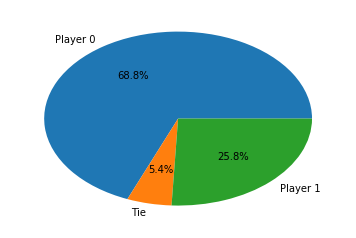

In [32]:
labels = [*map(lambda x: {-1:"Player 0", 1:"Player 1", 0:"Tie"}[x], labels)]
count = count / N
plt.pie(count, labels=labels, autopct='%.1f%%')
plt.show()

It probably did anywhere from not bad to abysmal right now. Let's train it for a while and see if it does better.

In [11]:
trainer = NNDETrainer(game.size, nNeurons, nNPlayer.exportWeightVector())
res = trainer.trainDE()

Optimization terminated successfully.
35
18534


In [12]:
nNPlayer.importWeightVector(res)

wincount= nGames(N, game)
labels, count = np.unique(wincount, return_counts=True)

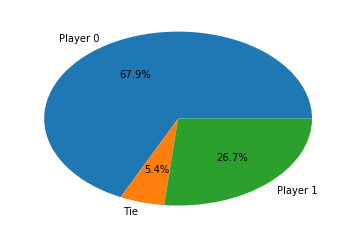

In [14]:
labels = [*map(lambda x: {-1:"Player 0", 1:"Player 1", 0:"Tie"}[x], labels)]
count = count / N
plt.pie(count, labels=labels, autopct='%.1f%%')
plt.show()

This almost always better, but considering tic-tac-toe is a solved game, that's an awful lot of computation for little gain. Bummer!

In [ ]:
#trained_vec = np.hstack((nnp.hiddenLayerWeights.ravel(), nnp.hiddenLayerBias.ravel(), nnp.outputLayerWeights.ravel()))

#trained_vec.tofile("trainedvec.csv")

In [71]:
gATrainer = NNGATrainer(10, 3)
gATrainer.updateScores()

array([ 0.51851852,  0.55555556,  0.38888889,  0.15740741, -0.12962963,
        0.27777778, -0.2037037 , -0.16666667, -0.2037037 , -0.14814815])